In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import matplotlib as plt

#NLP
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models

In [31]:
#df_JWC=pd.read_csv("JWC_alltweets.csv")
#Using non-retweets file for Topic Modeling
df_JWC=pd.read_csv("JWC_alltweets1.csv")

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
df_JWC

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Datetime,Unnamed: 0,Unnamed: 0.1,Tweet Id,Text,Username,User Location,Reply Count,Retweet Count,Like Count,Quote Count,Date,compound,Month,Clean Tweet,word list
0,2021-05-19 03:03:23+00:00,0,0,1394851147563872264,Water issues in the city again? SMH\n\n#Jacks...,FNULNU1,NaN,0,0,0,0,2021-05-19,-0.4648,5,water issues in the city again smh jacksonwate...,"[water, issues, city, smh, jacksonwatercrisis]"
1,2021-04-24 02:14:03+00:00,1,1,1385779037126148096,#JacksonWaterCrisis https://t.co/OFuCz2zYa9,Backstorymom1,NaN,0,0,0,0,2021-04-24,0.0000,4,jacksonwatercrisis,[jacksonwatercrisis]
2,2021-04-21 12:26:37+00:00,2,2,1384846032329138176,Anyone with mobile video of the #jacksonwaterc...,nicolahann,"New York, NY",0,0,0,0,2021-04-21,0.3400,4,anyone with mobile video of the jacksonwatercr...,"[anyone, mobile, video, jacksonwatercrisis, pl..."
3,2021-04-07 21:13:26+00:00,3,3,1379905176711073792,#FlintWaterCrisis #JacksonWaterCrisis https://...,JalenRoseBat,Imported from Detroit,0,0,0,0,2021-04-07,0.0000,4,flintwatercrisis jacksonwatercrisis,"[flintwatercrisis, jacksonwatercrisis]"
4,2021-03-22 23:57:03+00:00,5,5,1374148148172496899,Jackson Mississippi's Water Crisis is Rooted i...,ru2inept,The Twilight Zone,0,3,0,0,2021-03-22,-0.8481,3,jackson mississippi s water crisis is rooted i...,"[jackson, mississippi, water, crisis, rooted, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,2021-03-02 21:29:35+00:00,13,13,1366863278396346369,Governor: We’ll have to have a serious convers...,keeganfoxx,"Jackson, MS",0,1,1,0,2021-03-02,0.5413,3,governor we ll have to have a serious conversa...,"[governor, serious, conversation, long, term, ..."
2810,2021-02-28 17:40:09+00:00,14,14,1366080764719333376,@HindsEOC You nincompoops should fix the broke...,AlanBuckles,NaN,0,0,0,0,2021-02-28,-0.2124,2,hindseoc you nincompoops should fix the broke...,"[hindseoc, nincompoops, fix, broken, water, li..."
2811,2021-02-25 00:17:15+00:00,15,15,1364731148602134528,@kaylahazel_ our north been complaining about ...,GaredQuinn,"Jackson, MS",0,0,0,0,2021-02-25,0.3584,2,kaylahazel our north been complaining about w...,"[kaylahazel, north, complaining, water, house,..."
2812,2021-02-24 13:52:51+00:00,16,16,1364574012282728449,@jordanrhillman Exactly. He’ll take credit for...,FBrownWilliams,"Jackson, MS",0,0,0,0,2021-02-24,-0.0258,2,jordanrhillman exactly he ll take credit for ...,"[jordanrhillman, exactly, take, credit, fixing..."


In [33]:
#Preprocessing tweets- Cleaning, Tokenizing

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text=re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df_JWC['Clean Tweet']=df_JWC['Text'].apply(lambda x:clean_text(x))


def remove_stopwords(x):
    stopword=stopwords.words('english')
    stopword.append("amp")
    stopword.append("t")
    stopword.append("co")
    
   
    return [y for y in x if y not in stopword]


df_JWC['word list']=df_JWC['Clean Tweet'].apply(lambda x:str(x).split())
df_JWC['word list']=df_JWC['word list'].apply(lambda x:remove_stopwords(x))

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \w
<ipython-input-33-7ecc77be3e2c>:5: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', '', text)
<ipython-input-33-7ecc77be3e2c>:6: DeprecationWarning: invalid escape sequence \S
  text = re.sub('https?://\S+|www\.\S+', '', text)
<ipython-input-33-7ecc77be3e2c>:10:

In [35]:
#Lemmatization
# Make tokens a string again
import string
nlp = spacy.load('en_core_web_sm')
# import en_core_web_lg
# nlp = en_core_web_lg.load()

df_JWC['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df_JWC['word list']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df_JWC['lemmas'] = df_JWC['tokens_back_to_text'].apply(get_lemmas)


# Make lemmas a string again
df_JWC['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df_JWC['lemmas']]

# Tokenizer function
def tokenize(text):

    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df_JWC['lemma_tokens'] = df_JWC['lemmas_back_to_text'].apply(tokenize)



C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:38: DeprecationWarning: invalid escape sequence \w
<>:39: DeprecationWarning: invalid escape sequence \$
<>:38: DeprecationWarning: invalid escape sequence \w
<>:39: DeprecationWarning: invalid escape sequence \$
<ipython-input-35-0e7720cc207a>:38: DeprecationWarning: invalid escape sequence \w
  tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
<ipython-input-35-0e7720cc207a>:39: DeprecationWarning: invalid escape sequence \$
  tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $


In [36]:
def remove_stopwords_lemma(x):
    stopword=stopwords.words('english')
    stopword.append("amp")
    stopword.append("t")
    stopword.append("co")
    stopword.append('water')
    stopword.append('crisis')
    stopword.append('jackson')
    stopword.append('mississippi')
    stopword.append('jxnneedswater')
    stopword.append('jacksonwatercrisis')
    stopword.append('ms')
    stopword.append('city')
    stopword.append('state')
    stopword.append('problem')
   
    return [y for y in x if y not in stopword]

df_JWC['lemma_tokens_remstop']=df_JWC['lemma_tokens'].apply(lambda x:remove_stopwords_lemma(x))

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
df_JWC['lemma_tokens_remstop']

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0                                            [issue, smh]
1                                                      []
2            [mobile, video, reach, mignonn, cbsnew, com]
3                                      [flintwatercrisis]
4                     [root, racism, youtube, statuscoup]
                              ...                        
2809    [governor, conversation, long, term, intereste...
2810    [hindseoc, nincompoop, fix, broken, line, plan...
2811    [kaylahazel, north, complain, house, stay, north]
2812    [jordanrhillman, exactly, credit, fixing, exis...
2813                  [thank, tell, brush, tooth, noodle]
Name: lemma_tokens_remstop, Length: 2814, dtype: object

In [38]:
#Topic Modeling using LDA-- cReating a base LDA model(do lemmatization first?)

# Create a id2word dictionary
id2word = Dictionary(df_JWC['lemma_tokens'])
print(len(id2word))

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df_JWC['lemma_tokens']]

# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=4, id2word=id2word, workers=12, passes=5)
# base_model = LdaMulticore(corpus=corpus,
# id2word=id2word,
# chunksize=100000,
# num_topics=6,
# passes=20,
# workers=12,
# iterations=1000
# )
    
    
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5402
2436
------ Topic 0 ------
water jackson help crisis mississippi jacksonwatercrisis need month people pandemic

------ Topic 1 ------
water jackson crisis mississippi problem city week infrastructure black state

------ Topic 2 ------
water jackson crisis mississippi problem city resident state ms help

------ Topic 3 ------
water crisis jackson week storm continue miss mississippi failure gop



In [39]:
#Visualizing topic model- for 5 topics

import pyLDAvis
import pyLDAvis.gensim_models
#import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(base_model, corpus, dictionary=base_model.id2word)
vis

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.029683 -0.039364       1        1  50.569149
1      0.003693 -0.075937       2        1  23.970046
3      0.116969  0.046175       3        1  12.952445
0     -0.090979  0.069127       4        1  12.508360, topic_info=           Term         Freq        Total Category  logprob  loglift
22         help   287.000000   287.000000  Default  30.0000  30.0000
57         week   413.000000   413.000000  Default  29.0000  29.0000
56        storm   246.000000   246.000000  Default  28.0000  28.0000
11       crisis  1851.000000  1851.000000  Default  27.0000  27.0000
4         water  3213.000000  3213.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1537       fear    19.433384    80.157161   Topic4  -5.5012   0.6618
61        black    25.085989   181.282538   Topic4  -5.2459   0.1010
57         week    28.131636   413.059776   Topic4  -5.1313  -0.6079
278   tatereeve    19.392150   120.169641   Topic4  -5.5033   0.2547
0          city    21.313619   486.042950   Topic4  -5.4089  -1.0482

[313 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
413       1  0.062881            abc
413       2  0.901293            abc
413       3  0.041921            abc
454       3  0.831676     abolishice
1859      3  0.909799    acknowledge
...     ...       ...            ...
464       3  0.831686  yemencantwait
870       1  0.247284            yes
870       2  0.123642            yes
870       3  0.618210            yes
1706      3  0.866044           york

[564 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

In [47]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, corpus=corpus, texts=df_JWC['lemma_tokens'],
                                   dictionary=id2word, coherence='c_v')
with np.errstate(invalid='ignore'):
    
    coherence_lda_model_base = coherence_model.get_coherence()
    print('\nCoherence Score: ', coherence_lda_model_base)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -7.215459028048553

Coherence Score:  0.21892569882489238


In [10]:
#For Hyperparameter tuning

vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(df_JWC['lemmas_back_to_text'])

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 30]},
             return_train_score='warn')

In [11]:
# Best Model
best_lda_model = model.best_estimator_
print(best_lda_model)
# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_decay=0.9)
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -96512.53061111885
Model Perplexity:  587.3886318911643


In [12]:
# #Hyper parameter tuning
# lda=LdaMulticore(workers=12, passes=5,random_state=5,iterations=100, id2word=id2word)
# param_grid={'n_topics': [4,5,10, 15, 20, 30], 
#             'learning_decay': [0.5, 0.7, 0.9],
#            }
# model = GridSearchCV(cv=None, error_score='raise',
#              estimator=lda,
#              param_grid=param_grid,
#              pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#              scoring=None, verbose=0)


# model.fit(data_vectorized)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -96512.53061111885


C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model Perplexity:  587.3886318911643


In [45]:
#Finding Optimal number of topics- Approach->To build many LDA models with different values of number of topics 
#and pick the one that gives the highest coherence value

#Defining a function to loop over number of topics to be used to find an 
#optimal number of tipics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
   
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic

# Can take a long time to run.
model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_JWC['lemma_tokens'],
                                                        start=2, limit=200, step=6)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


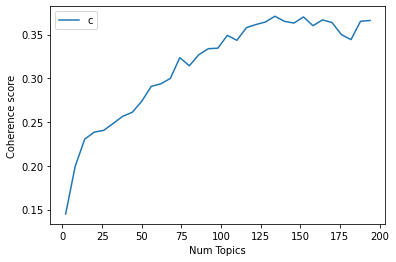

In [46]:
#Plotting graph for number of topics and coherence score
import matplotlib.pyplot as plt
%matplotlib inline

limit=200; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_topic)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [49]:
#Trying for different number of topics

id2word = Dictionary(df_JWC['lemma_tokens_remstop'])

id2word.filter_extremes(no_below=2, no_above=.99)

corpus = [id2word.doc2bow(d) for d in df_JWC['lemma_tokens_remstop']]


base_model = LdaMulticore(corpus=corpus, num_topics=4, id2word=id2word, workers=12, passes=5)

words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")
    
#Visualizing topics    
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(base_model, corpus, dictionary=base_model.id2word)
vis

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


------ Topic 0 ------
news ongoing infrastructure mayor help abc national time thank resident

------ Topic 1 ------
people black week help race legislature need resident hit hard

------ Topic 2 ------
week resident storm outage infrastructure continue month struggle winter miss

------ Topic 3 ------
help infrastructure long mayor break month racism issue say need



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.111661  0.056337       1        1  33.569481
3     -0.052136  0.062659       2        1  27.075804
1      0.034664 -0.110450       3        1  21.661933
0     -0.094189 -0.008545       4        1  17.692783, topic_info=             Term        Freq       Total Category  logprob  loglift
49          storm  231.000000  231.000000  Default  30.0000  30.0000
50           week  391.000000  391.000000  Default  29.0000  29.0000
40       struggle  105.000000  105.000000  Default  28.0000  28.0000
1525         fear   75.000000   75.000000  Default  27.0000  27.0000
613   legislature   53.000000   53.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
96       resident   28.686449  308.293139   Topic4  -5.1044  -0.6426
305          know   21.147315   97.443170   Topic4  -5.4093   0.2043
175        ignore   19.486751   69.096016   Topic4  -5.4910   0.4663
35           long   20.675847  128.889906   Topic4  -5.4318  -0.0980
47          right   18.716934   92.622842   Topic4  -5.5314   0.1329

[307 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
403       1  0.174894            abc
403       2  0.021862            abc
403       4  0.808886            abc
444       2  0.852325     abolishice
655       1  0.209665         affect
...     ...       ...            ...
338       4  0.236185           year
454       2  0.852331  yemencantwait
1694      3  0.891342           york
530       1  0.178594           zoom
530       3  0.892970           zoom

[633 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [54]:
pprint(base_model.print_topics())

[(0,
  '0.013*"news" + 0.010*"ongoing" + 0.010*"infrastructure" + 0.010*"mayor" + '
  '0.009*"help" + 0.008*"abc" + 0.007*"national" + 0.007*"time" + '
  '0.006*"thank" + 0.006*"resident"'),
 (1,
  '0.016*"people" + 0.014*"black" + 0.014*"week" + 0.011*"help" + 0.009*"race" '
  '+ 0.009*"legislature" + 0.007*"need" + 0.007*"resident" + 0.007*"hit" + '
  '0.006*"hard"'),
 (2,
  '0.031*"week" + 0.024*"resident" + 0.023*"storm" + 0.016*"outage" + '
  '0.013*"infrastructure" + 0.013*"continue" + 0.013*"month" + '
  '0.011*"struggle" + 0.010*"winter" + 0.010*"miss"'),
 (3,
  '0.014*"help" + 0.013*"infrastructure" + 0.012*"long" + 0.009*"mayor" + '
  '0.008*"break" + 0.008*"month" + 0.008*"racism" + 0.007*"issue" + '
  '0.007*"say" + 0.007*"need"')]


C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(base_model, corpus, dictionary=base_model.id2word)
vis

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.111661  0.056337       1        1  33.557979
3     -0.052136  0.062659       2        1  27.065930
1      0.034664 -0.110450       3        1  21.674038
0     -0.094189 -0.008545       4        1  17.702054, topic_info=             Term        Freq       Total Category  logprob  loglift
49          storm  231.000000  231.000000  Default  30.0000  30.0000
50           week  391.000000  391.000000  Default  29.0000  29.0000
40       struggle  105.000000  105.000000  Default  28.0000  28.0000
1525         fear   75.000000   75.000000  Default  27.0000  27.0000
613   legislature   53.000000   53.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
96       resident   28.701481  308.248035   Topic4  -5.1044  -0.6425
305          know   21.158397   97.436310   Topic4  -5.4093   0.2043
175        ignore   19.496962   69.113235   Topic4  -5.4910   0.4660
35           long   20.686681  128.872207   Topic4  -5.4318  -0.0978
47          right   18.726742   92.617116   Topic4  -5.5314   0.1330

[307 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
403       1  0.174831            abc
403       2  0.021854            abc
403       4  0.808595            abc
444       2  0.852559     abolishice
655       1  0.209620         affect
...     ...       ...            ...
338       4  0.236171           year
454       2  0.852564  yemencantwait
1694      3  0.890938           york
530       1  0.178518           zoom
530       3  0.892588           zoom

[633 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [44]:
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, corpus=corpus, texts=df_JWC['lemma_tokens'],
                                   dictionary=id2word, coherence='c_v')
with np.errstate(invalid='ignore'):
    
    coherence_lda_model_base = coherence_model.get_coherence()
    print('\nCoherence Score: ', coherence_lda_model_base)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -7.215454675310057

Coherence Score:  0.21892569882489238
